# Experimenting with docking

In [2]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [3]:
from openff.toolkit import Molecule, Topology, ForceField
top = Topology.from_pdb("selected_prediction.pdb")

In [4]:
top.visualize()

NGLWidget()

In [5]:
#!prepare_receptor -r selected_prediction.pdb -o receptor.pdbqt

In [6]:
#!mk_prepare_receptor.py --pdb selected_prediction.pdb -o receptor.pdbqt --box_center 45 "-18"  0  --box_size   10 10 10 

In [7]:
#mol = Molecule.from_smiles("c2c3ccccc3sc2C(=O)O")
#mol.generate_conformers()
#mol.to_file("core_scaffold.sdf", "sdf")
#mol.visualize()

In [8]:
#!mk_prepare_ligand.py -i core_scaffold.sdf -o core_scaffold.pdbqt

In [9]:
#! vina --receptor receptor.pdbqt --ligand core_scaffold.pdbqt \
#  --center_x 45 --center_y -18 --center_z 0 \
#  --size_x   10 --size_y    10 --size_z 10 \
#  --exhaustiveness=32 --out docking_results.pdbqt

In [10]:
# 2024-05-14 JM check in
# 1. Review current plans
# 2. Is current state acceptable?
# 3. Improvements that could be made. 

# Goal: Use OpenFF to grow a molecule into a blocked binding pocket 
# Intro: Looks, the binding site in the alphafold prediction is closed


# (maybe) Mixed solvent MD to open pocket? (show off how quickly we can do arbitrary small mols)
# (maybe) Dock using Vina
    # JW - I don't want to put too much behind the scenes - Could I just do a bunch of !commands? 
    # JM - Yes, that should be straightforward, didn't realize Vina was on c-f
# Cheat and pick the right pose
# Design optimization loop
    # Sort candidates by their objective function
    # Pick the best one
    # Minimize and rescore the best candidate using OpenFF?
        # Contrive a reason why we need to do force field modification (maybe to weaken protein torsions, or reduce vdw radii)
    # Mutate the minimized candidate in place
        # (maybe score by clashes or something)
    # Calculate new objective function for all new candidates
        # gmx sasa (show off gromacs export)? 
        # or mdtraj's shrake_rupley (show off interop)? https://mdtraj.org/1.9.4/api/generated/mdtraj.shrake_rupley.html#mdtraj.shrake_rupley


    

# Solvate or use GBSA (or just vacuum)
    # Explicit solvent will lead to atom clashes. Maybe leaning toward GBSA but that's a bit experimental
    # JM - Would certainly use GBSA before explicit solvent for this case. Using vacuum would be a clear message not to use it in production.
# (maybe) use bespokefit (but cheat and have the QC data already on my system)
# Export to a bunch of engines?
# 


# Essential todos
    # visualize surface for intro
    # Talk organization+practice
    # Workflow diagram

# Important todos
    # Better mutations

# Nice to haves


# Once we have the docked conf, load from PDB (currently using Irfan's post-sim frame)

In [11]:
lig = Molecule.from_smiles("c12c(Cl)cccc1sc(C(=O)[O-])c(Cl)2")
top = Topology.from_pdb("last_frame_lig.pdb",
                       unique_molecules=[lig])
#top = Topology.from_molecules([*top.molecules][:2])
protein = top.molecule(0)
ligand = top.molecule(1)

In [12]:
print(protein.n_atoms)
print(ligand.n_atoms)

2466
17


In [13]:
top.visualize()

NGLWidget()

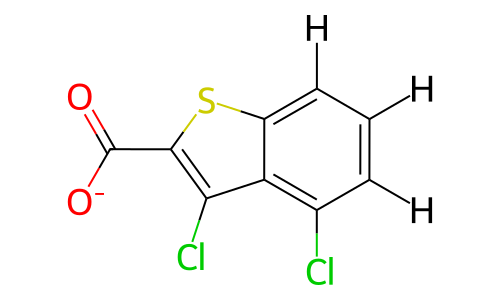

In [14]:
#rdmol = top.molecule(1).to_rdkit()
#rdmol
ligand.visualize()

In [15]:
ligand.to_file('posed_ligand.sdf', file_format="sdf")

# OR, start using posed ligand and JWei's raw output

In [16]:
# protein = Topology.from_pdb("selected_prediction_aligned.pdb").molecule(0)

# Use RDKit to start mutating molecule

In [17]:

import rdkit
def mutate_ligand(ligand):
    ligand.partial_charges = None
    rdmol = ligand.to_rdkit()
    rxn = rdkit.Chem.rdChemReactions.ReactionFromSmarts("[#6:1][*X1:2] >> [#6:1][C:2]")
    unsanitized_products = rxn.RunReactants([rdmol])
    
    products = list()
    for (product,) in unsanitized_products:
        mol_copy = rdkit.Chem.Mol(product)
        
        rdkit.Chem.SanitizeMol(mol_copy, rdkit.Chem.SANITIZE_ALL)
        rdkit.Chem.AssignStereochemistryFrom3D(mol_copy)
        rdkit.Chem.Kekulize(mol_copy, clearAromaticFlags=True)
        rdkit.Chem.SetAromaticity(mol_copy, rdkit.Chem.AromaticityModel.AROMATICITY_MDL)
        offmol = Molecule.from_rdkit(mol_copy)
        existing_metadata = [atom.metadata for atom in offmol.atoms if atom.metadata != {}][0]
        for atom in offmol.atoms:
            atom.metadata.update(existing_metadata)
            #print(atom.metadata)
        #print()
        products.append(offmol)
    return products

def display_molecule_grid(molecules, item_width=200):
    import ipywidgets as widgets
    
    items = []
    for product in molecules:
        item = widgets.Output()
        item.append_display_data(product.visualize('rdkit', width=item_width))
        items.append(item)
        
    return widgets.GridBox(
        items, 
        layout=widgets.Layout(grid_template_columns=f"repeat(3, {item_width+10}px)")
    )

In [18]:
#products2 = list()
#for product in products:
#    products2.extend(mutate_ligand(product))
products = mutate_ligand(ligand)
display_molecule_grid(products)


GridBox(children=(Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<IPython.core.displa…

In [19]:
products_list = products
products_list[4].visualize(backend="nglview")

NGLWidget()

# Do the same thing, looping over all products and saving their minimized conf as PDB

In [20]:
import openmm
import openmm.unit as omm_unit
def relax_ligand(protein_interchange, ligand_offmol, ligand_ff, name=""):
    from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
    from openff.interchange import Interchange
    ntkw = NAGLToolkitWrapper()
    ntkw.assign_partial_charges(ligand_offmol, "openff-gnn-am1bcc-0.1.0-rc.2.pt")
    ligand_interchange = sage.create_interchange(ligand_offmol.to_topology(), charge_from_molecules=[ligand_offmol])
    complex_interchange = protein_interchange.combine(ligand_interchange)
    omm_sys = complex_interchange.to_openmm_system()
    omm_top = complex_interchange.to_openmm_topology()
    
    
    restraint = openmm.CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2')
    omm_sys.addForce(restraint)
    restraint.addGlobalParameter('k', 100.0 * omm_unit.kilojoules_per_mole / omm_unit.nanometer)
    restraint.addPerParticleParameter('x0')
    restraint.addPerParticleParameter('y0')
    restraint.addPerParticleParameter('z0')
    
    for atom in omm_top.atoms():
        if atom.name in ['C', 'O', 'N', 'CA', 'S1X', 'O1X', 'O2X']:
            restraint.addParticle(atom.index, complex_interchange.positions[atom.index].to_openmm())
    
    # Construct and configure a Langevin integrator at 300 K with an appropriate friction constant and time-step
    integrator = openmm.LangevinIntegrator(
        300 * omm_unit.kelvin,
        1 / omm_unit.picosecond,
        0.002 * omm_unit.picoseconds,
    )
    
    simulation = openmm.app.Simulation(omm_top, omm_sys, integrator)
    simulation.context.setPositions(complex_interchange.positions.to_openmm())
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(300)
    simulation.step(1000)
    from openff.units.openmm import from_openmm
    state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
    omm_positions = state.getPositions()
    openmm.app.PDBFile.writeFile(simulation.topology, omm_positions, open(f'{name}.pdb', 'w'))
    complex_interchange.positions = from_openmm(omm_positions)
    
    return complex_interchange, state
    

In [21]:
ff14sb = ForceField("ff14sb_off_impropers_0.0.4.offxml")
protein_interchange = ff14sb.create_interchange(protein.to_topology())
#protein_interchange = ff14sb.create_interchange(top.molecule(0).to_topology())

In [22]:
env INTERCHANGE_EXPERIMENTAL=1

env: INTERCHANGE_EXPERIMENTAL=1


In [23]:
sage = ForceField("openff-2.2.0.offxml")
for idx, product in enumerate(products_list[:1]):
    print(product.to_smiles())
    relax_ligand(protein_interchange, product, sage, name=str(idx))
    
    

[H][c]1[c]([Cl])[c]2[c]([c]([H])[c]1[C]([H])([H])[H])[S][C]([C](=[O])[O-])=[C]2[Cl]


/home/joshmitchell/Documents/openff/symposium_2024_demo/.soap/test/lib/python3.11/site-packages/openff/interchange/components/interchange.py:954: UserWarning: Interchange object combination is experimental and likely to produce strange results. Any workflow using this method is not guaranteed to be suitable for production. Use with extreme caution and thoroughly validate results!
  return _combine(self, other)


In [24]:
import numpy as np
from openff.units import unit
def naive_objective(ligand):
    # CD of LEU76
    target_coord = (4.278,   1.307,   9.049)
    ligand_com = np.mean(ligand.conformers[0], axis=0).m_as(unit.angstrom)
    return np.linalg.norm(target_coord - ligand_com)
for idx, ligand in enumerate(products_list):
    print(idx, naive_objective(ligand))
          

0 9.895686144593387
1 9.641816886955413
2 10.236384555605296
3 9.696059202515285
4 10.583262311919688
5 10.04202091042908


In [25]:
candidates = [top.molecule(1)]

for idx in range(15):
    candidates.sort(key=lambda x: naive_objective(x))
    candidate = candidates.pop(0)
    complex_interchange, state = relax_ligand(protein_interchange, candidate, sage, name=str(idx))
    result_ligand = complex_interchange.topology.molecule(1)
    candidates.extend(mutate_ligand(result_ligand))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7c6b41d36f10>>
Traceback (most recent call last):
  File "/home/joshmitchell/Documents/openff/symposium_2024_demo/.soap/test/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import nglview
nglview.show_file("14.pdb")

# Aspirational workflow

In [25]:
# (JM) naive_objective gets changed to:
# * Will do an energy evaluation using a cached protein_simulation, cached protein coords, but a new ligand_interchange
# * Halve vdW radii/soften clashes
# * return tuple of objective_function (interaction energy)

# (TDB) relax_ligand gets changed to
# * make restraints stronger
# * accept protein coords
# * restain to ORIGINAL positions (don't let ligand scaffold and backbone walk away)
# * NOT return state


# (JW) mutate_ligand gets changed to:
# * NOT rely on rdkit's conf gen (since it'll fail on larger functional groups), but instead will do a constrained opt using Sage

# candidate list will be of the form (ligand_offmol, protein_coords, interaction_energy)
candidates = [(orig_ligand, orig_protein_coords, 999 kcal/mol)]
protein_simulation = softened_protein_interchange.to_openmm()

for idx in range(15):
    candidates.sort(key=lambda x: x[2])
    candidate = candidates.pop(0)
    # Relax using vanilla sage + ff14SB, get the minimized complex as an interchange
    complex_interchange = relax_ligand(protein_interchange, 
                                       orig_protein_coords, 
                                       candidate, 
                                       sage, 
                                       name=str(idx))
    result_ligand = complex_interchange.topology.molecule(1)
    # This comes up with chemical mutations AND new conformers, keeping the old atoms constrained.  
    mutations = mutate_ligand(result_ligand)
    for mutation in mutations:
        # This uses a softened version of Sage + ff14SB to calculate the protein-ligand interaction energy
        interaction_energy = naive_objective(mutation, complex_interchange.topology, protein_simulation)
        candidates.append(mutation, 
                          complex_interchange.topology.molecule(0).conformers[0], 
                          interaction_energy)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2655276914.py, line 17)

In [77]:
from openff.toolkit import Molecule, ForceField, Topology
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
from openff.units import Quantity, unit, ensure_quantity
from openmm.app import Simulation
from openff.interchange import Interchange
from openff.interchange.drivers.openmm import get_openmm_energies

softened_ff = ForceField("openff-2.2.0.offxml")
for parameter in softened_ff.get_parameter_handler('vdW'):
    parameter.rmin_half *= 0.5
# softened_ff.parse_sources(["ff14sb_off_impropers_0.0.4.offxml"])

def single_point_energy(simulation: Simulation, positions: Quantity, box_vectors: Quantity | None) -> Quantity:
    """Calculate a single point energy with OpenMM"""
    simulation.context.setPositions(ensure_quantity(positions, 'openmm'))
    if box_vectors is not None:
        simulation.context.setPeriodicBoxVectors(*ensure_quantity(box_vectors, 'openmm'))
    state = simulation.context.getState(getEnergy=True)
    return ensure_quantity(state.getPotentialEnergy(), 'openff')

def create_integrator() -> openmm.Integrator:
    return openmm.LangevinMiddleIntegrator(
        300 * omm_unit.kelvin,
        1 / omm_unit.picosecond,
        0.002 * omm_unit.picoseconds,
    )

def interaction_objective(
    ligand: Molecule,
    previous_complex: Topology,
    # protein_simulation: Simulation,
    protein_energy: Quantity,
    protein_interchange: Interchange,
    force_field: ForceField = softened_ff,
) -> Quantity:
    """
    Interaction energy between ligand and all but the last molecule in previous_complex.

    """
    ntkw = NAGLToolkitWrapper()
    ntkw.assign_partial_charges(ligand, "openff-gnn-am1bcc-0.1.0-rc.2.pt")

    # # protein_energy = single_point_energy(protein_simulation, previous_complex.molecule(0).conformers[0], protein_interchange.box)
    # protein_interchange.positions = previous_complex.molecule(0).conformers[0]
    # protein_energy = get_openmm_energies(protein_interchange).total_energy

    ligand_interchange = force_field.create_interchange(ligand.to_topology(), charge_from_molecules=[ligand])
    ligand_energy = get_openmm_energies(ligand_interchange).total_energy

    complex_interchange = protein_interchange.combine(ligand_interchange)
    complex_energy = get_openmm_energies(complex_interchange).total_energy
    
    interaction_energy = complex_energy - protein_energy - ligand_energy
    return interaction_energy

In [64]:
protein_simulation = protein_interchange.to_openmm_simulation(create_integrator())

In [79]:
# %%snakeviz

import mdtraj
import numpy 
from multiprocessing import Pool
from functools import partial

import sys
sys.setrecursionlimit(6000)


candidates = [(top.molecule(1), 999)]
protein_trajectory = mdtraj.Trajectory(protein_interchange.positions.m, mdtraj.Topology.from_openmm(protein_interchange.topology.to_openmm()))

def compute_mutation(
    complex_interchange, 
    # protein_simulation, 
    protein_energy,
    protein_interchange, 
    mutation
):
    print(f"computing {mutation}")
    ret = (
        mutation, 
        interaction_objective(
            mutation, 
            complex_interchange.topology, 
            # protein_simulation, 
            protein_energy,
            protein_interchange
        )
    )
    print(f"finished {mutation} with energy {ret[1]}")
    return ret

for idx in range(15):
    print(f"round {idx}")
    candidate, energy = candidates.pop(0)
    
    print(f"Relaxing candidate")
    complex_interchange, state = relax_ligand(protein_interchange, candidate, sage, name=str(idx))
    protein_trajectory.xyz = [*protein_trajectory.xyz, complex_interchange.positions[:-candidate.n_atoms].m_as(unit.nanometer)]
    result_ligand = complex_interchange.topology.molecule(1)

    print(f"Computing protein point energy")
    protein_energy = single_point_energy(protein_simulation, complex_interchange.topology.molecule(0).conformers[0], complex_interchange.box)

    print(f"generating mutations")
    mutations = mutate_ligand(result_ligand)
    
    print(f"computing mutations")
    with Pool() as pool:
        new_candidates = [*pool.map(
            partial(compute_mutation, complex_interchange, protein_energy, protein_interchange), 
            mutations,
            chunksize=1,
        )]
    
    # # This does the same thing as the pool above, but without parallelism
    # new_candidates = [compute_mutation(complex_interchange, protein_energy, protein_interchange, mutation) for mutation in mutations]
    
    candidates.extend(new_candidates)
    candidates.sort(key=lambda x: x[1])

round 0
Relaxing candidate
Computing protein point energy
generating mutations
computing mutations
computing Molecule with name '' and SMILES '[H][c]1[c]([Cl])[c]2[c]([c]([H])[c]1[C]([H])([H])[H])[S][C]([C](=[O])[O-])=[C]2[Cl]'
finished Molecule with name '' and SMILES '[H][c]1[c]([Cl])[c]2[c]([c]([H])[c]1[C]([H])([H])[H])[S][C]([C](=[O])[O-])=[C]2[Cl]' with energy -422.34779384898627 kilojoule / mole
computing Molecule with name '' and SMILES '[H][c]1[c]([H])[c]([C]([H])([H])[H])[c]([Cl])[c]2[c]1[S][C]([C](=[O])[O-])=[C]2[Cl]'
finished Molecule with name '' and SMILES '[H][c]1[c]([H])[c]([C]([H])([H])[H])[c]([Cl])[c]2[c]1[S][C]([C](=[O])[O-])=[C]2[Cl]' with energy -426.92411750745487 kilojoule / mole
computing Molecule with name '' and SMILES '[H][c]1[c]([H])[c]([C]([H])([H])[H])[c]2[c]([c]1[Cl])[C]([Cl])=[C]([C](=[O])[O-])[S]2'
finished Molecule with name '' and SMILES '[H][c]1[c]([H])[c]([C]([H])([H])[H])[c]2[c]([c]1[Cl])[C]([Cl])=[C]([C](=[O])[O-])[S]2' with energy -424.24713160099

ValueError: Particle position is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

In [81]:
import nglview

w = nglview.show_mdtraj(protein_trajectory)
# w.add_surface(opacity=0.2)
w.add_line()
w

NGLWidget(max_frame=11)

In [82]:
complex_interchange.visualize()

NGLWidget()

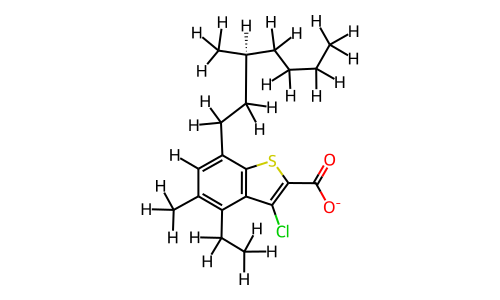

In [83]:
candidates[0][0].visualize()

# Scratch space

In [172]:
import copy
# Get full simulation energy
state = simulation.context.getState(getForces=False, getEnergy=True)
total_energy = state.getPotentialEnergy()


temp_sys = copy.deepcopy(omm_sys)
nbf = [i for i in temp_sys.getForces() if "onbond" in str(i)][0]

# Turn off protein nonbonded (get ligand energy)
for particle in range(top.molecule(0).n_atoms):
    #_, sigma, epsilon = nbf.getParticleParameters
    nbf.setParticleParameters(particle, 0., 0., 0.)
# Get just-ligand system energy
integrator = openmm.LangevinIntegrator(
    300 * omm_unit.kelvin,
    1 / omm_unit.picosecond,
    0.002 * omm_unit.picoseconds,
)

ligand_simulation = openmm.app.Simulation(omm_top, temp_sys, integrator)
ligand_simulation.context.setPositions(simulation.context.getState(getPositions=True).getPositions())
ligand_energy = ligand_simulation.context.getState(getEnergy=True).getPotentialEnergy()


# Make another copy
temp_sys = copy.deepcopy(omm_sys)
nbf = [i for i in temp_sys.getForces() if "onbond" in str(i)][0]

# Turn off LIGAND nonbonded
for particle in range(top.molecule(0).n_atoms, nbf.getNumParticles()) :
    #_, sigma, epsilon = nbf.getParticleParameters
    nbf.setParticleParameters(particle, 0., 0., 0.)

# Get just-protein system energy
integrator = openmm.LangevinIntegrator(
    300 * omm_unit.kelvin,
    1 / omm_unit.picosecond,
    0.002 * omm_unit.picoseconds,
)

protein_simulation = openmm.app.Simulation(omm_top, temp_sys, integrator)
protein_simulation.context.setPositions(simulation.context.getState(getPositions=True).getPositions())
protein_energy = protein_simulation.context.getState(getEnergy=True).getPotentialEnergy()

#nbf.setParticleParameters?
#from openmm import XmlSerializer
#XmlSerializer.serialize(state)
print(f"{total_energy=} {ligand_energy=} {protein_energy=}")

total_energy=Quantity(value=-12382.043884277344, unit=kilojoule/mole) ligand_energy=Quantity(value=41751.21142578125, unit=kilojoule/mole) protein_energy=Quantity(value=-12016.8017578125, unit=kilojoule/mole)


In [115]:
import rdkit
rxn = rdkit.Chem.rdChemReactions.ReactionFromSmarts("[#6:1][*X1:2] >> [#6:1][C:2]")
unsanitized_products = rxn.RunReactants([rdmol])

# Since some substitutions won't actually lead to a "new" molecule, only keep
# unique molecules
products = list()
for (product,) in unsanitized_products:
    mol_copy = rdkit.Chem.Mol(product)
    
    rdkit.Chem.SanitizeMol(mol_copy, rdkit.Chem.SANITIZE_ALL)
    rdkit.Chem.AssignStereochemistryFrom3D(mol_copy)
    rdkit.Chem.Kekulize(mol_copy, clearAromaticFlags=True)
    rdkit.Chem.SetAromaticity(mol_copy, rdkit.Chem.AromaticityModel.AROMATICITY_MDL)
    
    products.append(Molecule.from_rdkit(mol_copy))

In [159]:
dir(state)

['Energy',
 'Forces',
 'IntegratorParameters',
 'ParameterDerivatives',
 'Parameters',
 'Positions',
 'Velocities',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__weakref__',
 '_getNumParticles',
 '_getVectorAsNumpy',
 '_getVectorAsVec3',
 'getDataTypes',
 'getEnergyParameterDerivatives',
 'getForces',
 'getKineticEnergy',
 'getParameters',
 'getPeriodicBoxVectors',
 'getPeriodicBoxVolume',
 'getPositions',
 'getPotentialEnergy',
 'getStepCount',
 'getTime',
 'getVelocities',
 'this',
 'thisown']

In [157]:
import nglview
nglview.show_file("14.pdb")

NGLWidget()

In [32]:
!cat 0.pdb > xxx.pdb
!echo "ENDMDL" >> xxx.pdb
!cat 1.pdb >> xxx.pdb

In [33]:
nglview.show_file("xxx.pdb")

NGLWidget()

In [42]:
import rdkit.Chem.AllChem
[i for i in dir(rdkit.Chem.AllChem) if "onform" in i]

['AlignMolConformers',
 'CanonicalizeConformer',
 'Conformer',
 'GetConformerRMS',
 'GetConformerRMSMatrix',
 'NoConformers',
 'TransformConformer']

### Objective function
for number_of_generations:
    Mutate terminal C-[*X1] moieties using a bunch of prepared reactions
    Quickly evaluate whether naive coords make objective function worse
    Minimize to get better coords
    Check whether the energy is really bad/there are clashes
        Eval protein-ligand vdw MINUS protein vdW MINUS ligand vdW
        Use some mdanalysis tool to explicitly evaluate contact surface area (unable to find anything here)
        
    Evaluate objective

    

In [173]:
complex_interchange.to_gromacs("xxx")

NotImplementedError: If some atoms have residue names, all atoms must have residue names.

# Do a non-looped run of code to parameterize, restrain, and simulate mutated ligand

In [2]:
ff14sb = ForceField("ff14sb_off_impropers_0.0.4.offxml")
protein_interchange = ff14sb.create_interchange(top.molecule(0).to_topology())

In [3]:
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
ntkw = NAGLToolkitWrapper()
#print(NAGLToolkitWrapper.list_available_nagl_models())
product = products_list[0]
ntkw.assign_partial_charges(product, "openff-gnn-am1bcc-0.1.0-rc.2.pt")
sage = ForceField("openff-2.2.0.offxml")
product_interchange = sage.create_interchange(product.to_topology(), charge_from_molecules=[product])

NameError: name 'products_list' is not defined

In [ ]:
env INTERCHANGE_EXPERIMENTAL=1

In [ ]:
complex_interchange = protein_interchange.combine(product_interchange)
complex_interchange.visualize()

In [ ]:
import openmm
import openmm.unit as omm_unit
omm_sys = complex_interchange.to_openmm_system()
omm_top = complex_interchange.to_openmm_topology()


restraint = openmm.CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2')
omm_sys.addForce(restraint)
restraint.addGlobalParameter('k', 100.0 * omm_unit.kilojoules_per_mole / omm_unit.nanometer)
restraint.addPerParticleParameter('x0')
restraint.addPerParticleParameter('y0')
restraint.addPerParticleParameter('z0')

for atom in omm_top.atoms():
    if atom.name in ['C', 'O', 'N', 'CA', 'S1X', 'O1X', 'O2X']:
        restraint.addParticle(atom.index, complex_interchange.positions[atom.index].to_openmm())

# Construct and configure a Langevin integrator at 300 K with an appropriate friction constant and time-step
integrator = openmm.LangevinIntegrator(
    300 * omm_unit.kelvin,
    1 / omm_unit.picosecond,
    0.002 * omm_unit.picoseconds,
)

simulation = openmm.app.Simulation(omm_top, omm_sys, integrator)
simulation.context.setPositions(complex_interchange.positions.to_openmm())
simulation.context.setVelocitiesToTemperature(300)
simulation.step(1000)



# Under the hood, this creates *OpenMM* `System` and `Topology` objects, then combines them together
#simulation = interchange.to_openmm_simulation(integrator=integrator)

In [ ]:
dir(simulation.context)

In [ ]:
from openff.units.openmm import from_openmm
omm_positions = simulation.context.getState(getPositions=True).getPositions()
openmm.app.PDBFile.writeFile(simulation.topology, omm_positions, open('output.pdb', 'w'))
complex_interchange.positions = from_openmm(omm_positions)
complex_interchange.visualize()

In [79]:
nv = nglview.show_file("selected_prediction_aligned.pdb")
nv.add_surface("protein", opacity=0.3)
nv

NGLWidget()

In [81]:
nv = nglview.show_file("14.pdb")
nv.add_surface("protein", opacity=0.3)
nv

NGLWidget()

In [87]:
#nv.stage.viewerControls.getOrientation()
nv.get_state()['_camera_orientation']

[34.26784431824785,
 -37.69383848160029,
 -41.627593206517496,
 0,
 0.2801427587500124,
 48.87981942700043,
 -44.03012494511565,
 0,
 56.15695411682329,
 22.75752453960679,
 25.621450212939713,
 0,
 0.15315628051757812,
 -1.7593145370483398,
 3.26180362701416,
 1]

In [86]:
nv.get_state()

{'_camera_orientation': [34.26784431824785,
  -37.69383848160029,
  -41.627593206517496,
  0,
  0.2801427587500124,
  48.87981942700043,
  -44.03012494511565,
  0,
  56.15695411682329,
  22.75752453960679,
  25.621450212939713,
  0,
  0.15315628051757812,
  -1.7593145370483398,
  3.26180362701416,
  1],
 '_camera_str': 'orthographic',
 '_dom_classes': (),
 '_gui_theme': None,
 '_ibtn_fullscreen': 'IPY_MODEL_74aec1543d284357ba9bd04fd5bbacd7',
 '_igui': None,
 '_iplayer': 'IPY_MODEL_88fdf8e40fb1486593ee48c389a0206a',
 '_model_module': 'nglview-js-widgets',
 '_model_module_version': '3.1.0',
 '_model_name': 'NGLModel',
 '_ngl_color_dict': {},
 '_ngl_coordinate_resource': {},
 '_ngl_full_stage_parameters': {'impostor': True,
  'quality': 'medium',
  'workerDefault': True,
  'sampleLevel': 0,
  'backgroundColor': 'white',
  'rotateSpeed': 2,
  'zoomSpeed': 1.2,
  'panSpeed': 1,
  'clipNear': 0,
  'clipFar': 100,
  'clipDist': 10,
  'clipMode': 'scene',
  'clipScale': 'relative',
  'fogNear'

In [83]:
dir(nv.stage)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_view',
 'set_parameters']

In [84]:
dir(nv)

['__annotations__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_active_widgets',
 '_add_notifiers',
 '_add_shape',
 '_all_trait_default_generators',
 '_call_widget_constructed',
 '_camera_orientation',
 '_camera_str',
 '_clear_component_auto_completion',
 '_comm_changed',
 '_compare',
 '_control_comm',
 '_coordinates_dict',
 '_create_ibtn_fullscreen',
 '_create_player',
 '_cross_validation_lock',
 '_default_keys',
 '_descriptors',
 '_display_image',
 '_display_repr',
 '_dom_classes',
 '_dry_run',
 '_event',
 '_execute_js_code',
 '_fire_callbacks',
 '_gen_repr_